In [1]:
%config InlineBackend.figure_formats = ['retina']

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_regression, f_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import statsmodels.api as sm
from linearmodels import PanelOLS

sns.set()

In [3]:
scraping_date = '_26_04_2021'
data = pd.read_csv('data/dummies'+scraping_date+'.csv')

In [4]:
data

,rating,nb_reviews,Price/hour in USD,nb_projects,nb_buyers,last_active,gender,score,male,female,...,Sotho_lang,Zulu_lang,Kikuyu_lang,Tigrinya_lang,Nynorsk_lang,Twi_lang,Nyanja_lang,Oriya_lang,Akan_lang,Khmer_lang
0,4.9,4694,34.74,7672,4168,1,1,10.043,0,1,...,0,0,0,0,0,0,0,0,0,0
1,5.0,1190,138.95,1085,533,1,2,8.691,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.9,598,20.00,721,376,1,2,7.983,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.9,135,27.79,140,100,1,2,6.496,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.9,554,22.23,404,293,1,0,7.907,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7068,5.0,1,11.12,1,1,0,2,1.792,0,0,...,0,0,0,0,0,0,0,0,0,0
7069,5.0,6,48.34,5,4,0,2,3.434,0,0,...,0,0,0,0,0,0,0,0,0,0
7070,4.5,2,13.29,2,2,1,0,2.303,1,0,...,0,0,0,0,0,0,0,0,0,1
7071,4.7,18,41.68,25,18,0,0,4.450,1,0,...,0,0,0,0,0,0,0,0,0,0


# ANOVA F-value For Feature Selection
https://www.kaggle.com/prashant111/comprehensive-guide-on-feature-selection/notebook

In [5]:
X = data.drop(['Price/hour in USD', 'rating', 'nb_reviews', 'nb_projects', 'nb_buyers'], axis=1)
y = data['Price/hour in USD']

In [6]:
X.shape, y.shape

((7073, 404), (7073,))

Compute the ANOVA F-value for the provided sample.

The F-value scores examine if, when we group the numerical feature by the target vector, the means for each group are significantly different.

Compare Chi-Squared Statistics

## Compare the R^2 for different number of features

### With the simple data set

In [7]:
nb_features = X.shape[1] # because there we need to remove the y from the features

In [8]:
# Select Features With Best ANOVA F-Values
rsquared = []
selected_cols = {} # keys are the number of features and values are lists of the indices of the selected features
for i in range(0,nb_features,10):
    selector = SelectKBest(f_classif, k=i)
    selector.fit(X,y)
    cols = selector.get_support(indices=True)
    X_new = X.iloc[:,cols]
    X_new = X_new.assign(Intercept=1)
    model = sm.OLS(y, X_new).fit()
    rsquared.append(model.rsquared)
    selected_cols[i] = cols

Text(0.5, 1.0, 'Evolution of the R-squared with respect to the number of features in the model')

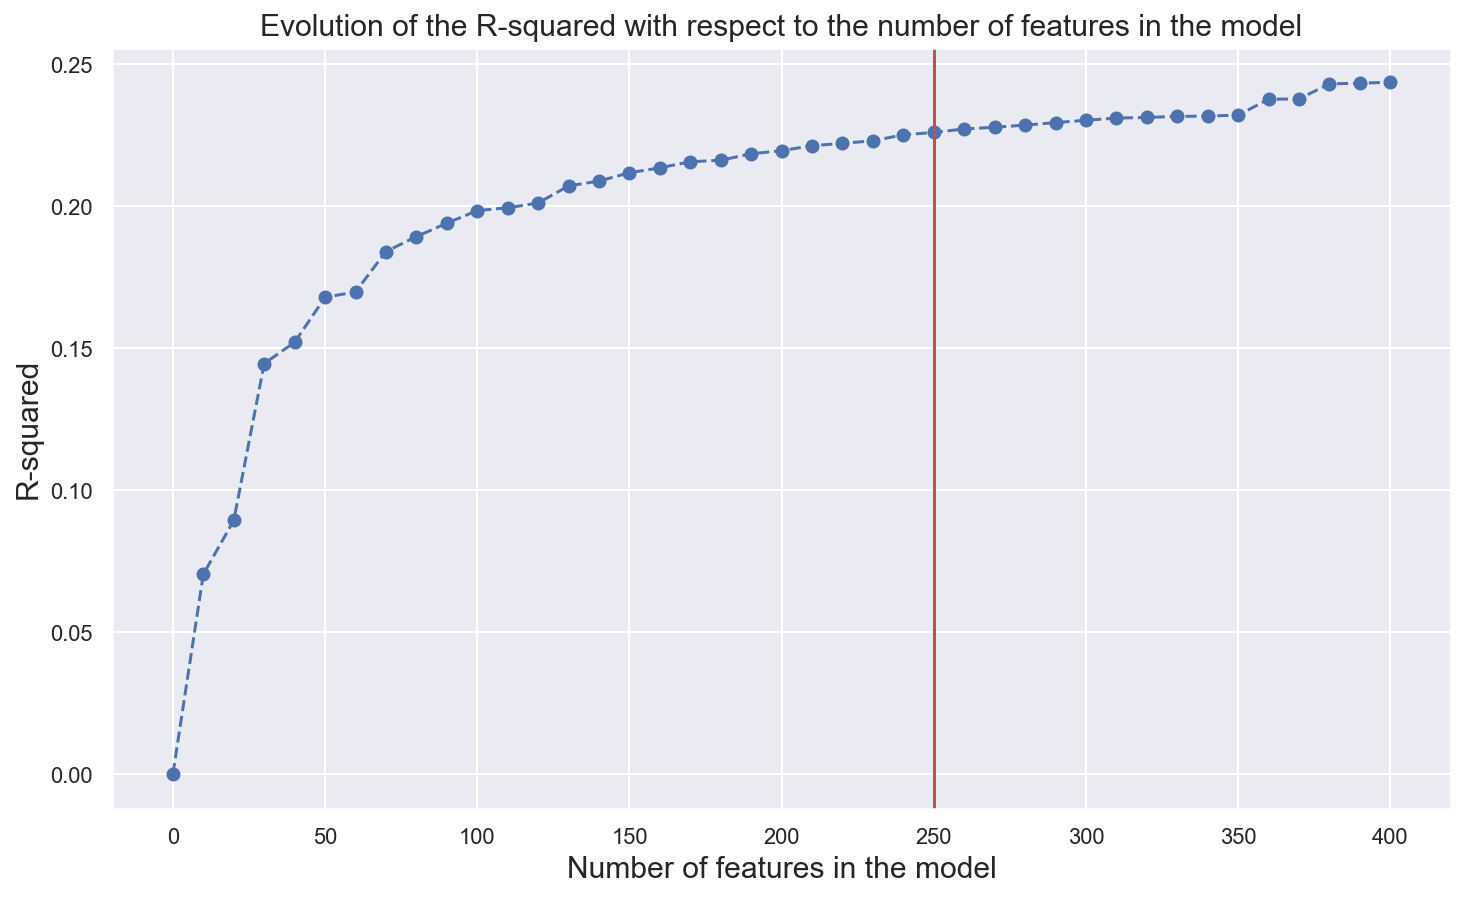

In [37]:
plt.figure(figsize=(12,7))
x = range(0,nb_features,10)
plt.plot(x,rsquared, '--', c='b', marker='o')
plt.xlabel('Number of features in the model', size=15)
plt.axvline(250, 0, 1, c='r')
plt.ylabel('R-squared', size=15)
plt.title('Evolution of the R-squared with respect to the number of features in the model', size=15)

From the plot, we can see that after 200 features, the $R^{2}$ is increasing slowly, therefore we could choose to use 250 features in our model. The selected features are as follows:

# Ordered the features with p-values

In [10]:
model = sm.OLS(y,X).fit()

In [11]:
sorted_features = model.pvalues.sort_values()

## Regression with the 100 most important features (with the lowest p-values)

In [12]:
nb_features_selected = 15
top_ft = sorted_features[:nb_features_selected]

if 'score' in top_ft and 'gender' in top_ft:
    ordered_features = ['score', 'gender'] + list(top_ft.drop(['score', 'gender']).index)
elif 'score' in top_ft:
    ordered_features = ['score', 'gender'] + list(top_ft.drop(['score']).index)
elif 'gender' in top_ft:
    ordered_features = ['score', 'gender'] + list(top_ft.drop(['gender']).index)
else:
    ordered_features = ['score', 'gender'] + list(top_ft.index)

In [13]:
X_cut = X[ordered_features]
X_cut = sm.add_constant(X_cut)
X_cut = X_cut

/Users/Victor/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [14]:
model_cut = sm.OLS(y,X_cut).fit()
print(model_cut.summary())

                            OLS Regression Results                            
Dep. Variable:      Price/hour in USD   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     101.8
Date:                Fri, 11 Jun 2021   Prob (F-statistic):          1.03e-268
Time:                        09:22:04   Log-Likelihood:                -34453.
No. Observations:                7073   AIC:                         6.894e+04
Df Residuals:                    7058   BIC:                         6.904e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

# Optimization of R^2 for each feature category
The categories are: countries, skills, expertises and languages

## Order the features
Consider the number of occurences of each value to order them

### For the countries

In [15]:
country_features = [country for country in data.columns if '_country' in country]
ordered_c_features = list(data[country_features].sum(axis=0).sort_values(ascending=False).index)

In [16]:
skills_features = [skills for skills in data.columns if '_skill' in skills]
ordered_s_features = list(data[skills_features].sum(axis=0).sort_values(ascending=False).index)

In [17]:
exper_features = [exper for exper in data.columns if '_exper' in exper]
ordered_e_features = list(data[exper_features].sum(axis=0).sort_values(ascending=False).index)

In [18]:
lang_features = [lang for lang in data.columns if '_lang' in lang]
ordered_l_features = list(data[lang_features].sum(axis=0).sort_values(ascending=False).index)

## For the countries

In [19]:
important_countries = []
selected_features = ['last_active','gender','score']
countries_rsquared = []
x_countries = []
for country in ordered_c_features:
    if country not in data.columns:
        continue
    selected_features += [country]
    X_cut = X[selected_features]
    X_cut = X_cut.assign(Intercept=1)
    model = sm.OLS(y,X_cut).fit()
    if len(countries_rsquared)>0:
        evol = (model.rsquared-countries_rsquared[-1])/countries_rsquared[-1]
        if evol>0.002:
            important_countries.append(country)
    else:
        important_countries.append(country)
    countries_rsquared.append(model.rsquared)
    x_countries.append(len(selected_features))

In [20]:
important_countries, len(important_countries)

(['United Kingdom_country',
  'India_country',
  'Pakistan_country',
  'Kenya_country',
  'France_country',
  'Germany_country',
  'Spain_country',
  'Bangladesh_country',
  'Nigeria_country',
  'Egypt_country',
  'Canada_country',
  'Philippines_country',
  'Netherlands_country',
  'Ireland_country',
  'Australia_country',
  'United Arab Emirates_country',
  'Morocco_country',
  'Belgium_country',
  'Venezuela_country',
  'Thailand_country',
  'Sweden_country',
  'New Zealand_country',
  'Switzerland_country',
  'Israel_country',
  'Japan_country'],
 25)

## For the skills

In [21]:
important_skills = []
selected_features = ['last_active','gender','score']
skills_rsquared = []
x_skills = []
for skill in ordered_s_features:
    if skill not in data.columns:
        continue
    selected_features += [skill]
    X_cut = X[selected_features]
    X_cut = X_cut.assign(Intercept=1)
    model = sm.OLS(y,X_cut).fit()
    if len(skills_rsquared)>0:
        evol = (model.rsquared-skills_rsquared[-1])/skills_rsquared[-1]
        if evol>0.01:
            important_skills.append(skill)
    else:
        important_skills.append(skill)
    skills_rsquared.append(model.rsquared)
    x_skills.append(len(selected_features))

In [22]:
important_skills, len(important_skills)

(['content writing_skill',
  'proofreading_skill',
  'marketing_skill',
  'copywriting_skill',
  'article_skill',
  'english translation_skill',
  'search engine optimization_skill',
  'creative writing_skill',
  'social media marketing_skill',
  'web writing_skill',
  'transcription_skill',
  'research writing_skill',
  'business writing_skill',
  'data entry_skill',
  'microsoft excel_skill',
  'virtual assistant_skill',
  'wordpress_skill',
  'microsoft word_skill',
  'internet research_skill',
  'guest blogging_skill',
  'project management_skill',
  'adobe photoshop_skill',
  'marketing strategy_skill',
  'voice over_skill',
  'guest posting_skill',
  'business advice/ business consulting_skill',
  'legal writing_skill',
  'business development_skill',
  'advice/consult and guidance_skill'],
 29)

## For the industry expertises

In [23]:
important_exper = []
selected_features = ['last_active','gender','score']
exper_rsquared = []
x_exper = []
for exper in ordered_e_features:
    if exper not in data.columns:
        continue
    selected_features += [exper]
    X_cut = X[selected_features]
    X_cut = X_cut.assign(Intercept=1)
    model = sm.OLS(y,X_cut).fit()
    if len(exper_rsquared)>0:
        evol = (model.rsquared-exper_rsquared[-1])/exper_rsquared[-1]
        if evol>0.01:
            important_exper.append(exper)
    else:
        important_exper.append(exper)
    exper_rsquared.append(model.rsquared)
    x_exper.append(len(selected_features))

In [24]:
important_exper, len(important_exper)

(['marketing_exper',
  'it_exper',
  'education_exper',
  'advertising_exper',
  'technology_exper',
  'internet_exper',
  'entertainment_exper',
  'financial services_exper',
  'pr_exper',
  'art_exper',
  'human resources_exper',
  'legal_exper',
  'retail_exper',
  'medical_exper',
  'news_exper',
  'government_exper',
  'recruitment_exper',
  'broadcasting_exper',
  'electronics_exper',
  'fmcg_exper',
  'insurance_exper',
  'agriculture_exper'],
 22)

## For the languages

In [25]:
important_lang = []
selected_features = ['last_active','gender','score']
lang_rsquared = []
x_lang = []
for lang in ordered_l_features:
    if lang not in data.columns:
        continue
    selected_features += [lang]
    X_cut = X[selected_features]
    X_cut = X_cut.assign(Intercept=1)
    model = sm.OLS(y,X_cut).fit()
    if len(lang_rsquared)>0:
        evol = (model.rsquared-lang_rsquared[-1])/lang_rsquared[-1]
        if evol>0.01:
            important_lang.append(lang)
    else:
        important_lang.append(lang)
    lang_rsquared.append(model.rsquared)
    x_lang.append(len(selected_features))

In [26]:
important_lang, len(important_lang)

(['English_lang',
  'German_lang',
  'Hindi_lang',
  'Urdu_lang',
  'Arabic_lang',
  'Russian_lang',
  'Portuguese_lang',
  'Dutch_lang',
  'Bengali_lang',
  'Swahili_lang',
  'Turkish_lang',
  'Japanese_lang',
  'Romanian_lang',
  'Serbian_lang',
  'Tagalog_lang',
  'Korean_lang',
  'Bulgarian_lang',
  'Latin_lang',
  'Akan_lang',
  'Wolof_lang',
  'Twi_lang'],
 21)

## Plot of the results

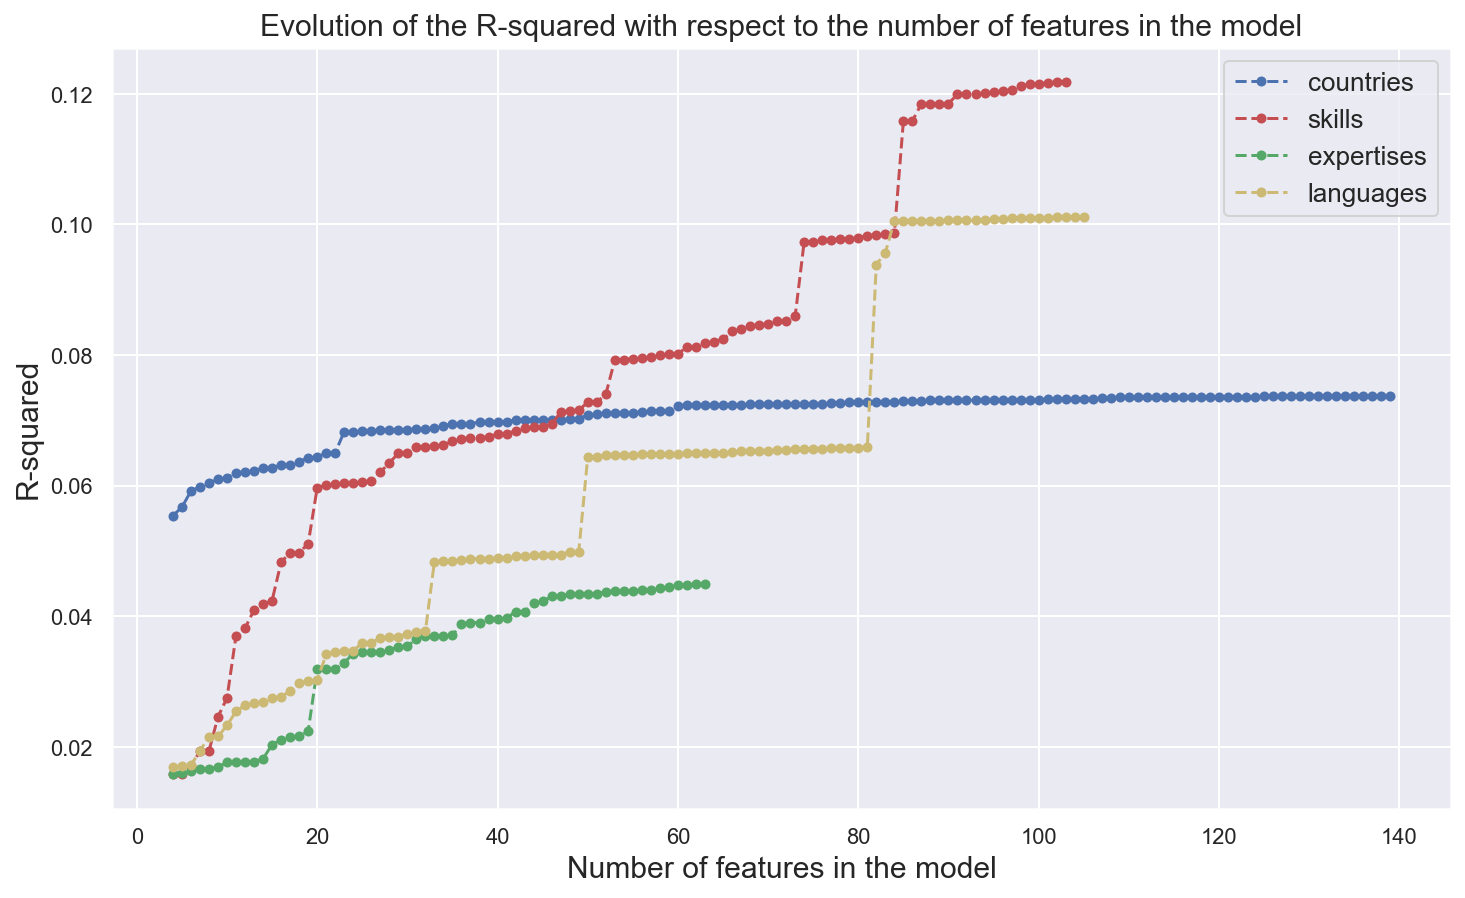

In [45]:
plt.figure(figsize=(12,7))
plt.plot(x_countries,countries_rsquared, '--', c='b', marker='o', ms=4, label='countries')
plt.plot(x_skills,skills_rsquared, '--', c='r', marker='o', ms=4, label='skills')
plt.plot(x_exper,exper_rsquared, '--', c='g', marker='o', ms=4, label='expertises')
plt.plot(x_lang,lang_rsquared, '--', c='y', marker='o', ms=4, label='languages')
plt.title('Evolution of the R-squared with respect to the number of features in the model', size=15)
plt.xlabel('Number of features in the model', size=15)
plt.ylabel('R-squared', size=15)
plt.legend(fontsize=13)

# Regression with the 250 best features

In [ ]:
X_best = X.iloc[:,selected_cols[250]]
X_best = X_best.assign(Intercept=1)
interaction_term = data.gender*data.score
X_best['genderXscore'] = interaction_term

In [ ]:
X_best = X_best.drop(['gender', 'male'],axis=1)

In [ ]:
model = sm.OLS(y,X_best).fit()
print(model.summary().as_latex())

# Regression with the best features of each category

In [ ]:
important_features = ['score', 'female', 'unknown', 'last_active']+important_countries+important_skills+important_exper+important_lang

In [ ]:
interaction_term = data.gender*data.score
X_important = X[important_features]
X_important['genderXscore'] = interaction_term
X_important = sm.add_constant(X_important)

In [ ]:
model_imp = sm.OLS(y,X_important).fit()
print(model_imp.summary().as_latex())

# Correlation between features

In [ ]:
X_best.corr()

In [ ]:
X_corr = X_best.drop('Intercept', axis=1)
test = np.array(X_corr.corr()-np.eye(X_corr.corr().shape[0]))
names = X_corr.columns

In [ ]:
indices = np.argmax(test,axis=0)
values = np.max(test,axis=0)
for i,el in enumerate(values):
    if el>0.6:
        print('{} and {} are highly correlated: {}'.format(names[i], names[indices[i]], round(el,3)))